In [55]:
import data
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

## load files by cell type

In [2]:
# list types of cells
subsets = data.prep_filename_metadata()
subsets['SubSet'].unique()
all_types = list(subsets['SubSet'].unique())
all_types

['CD4_Th2',
 'CD8_Effector',
 'B_CD5',
 'B_Memory',
 'CD4_Th1',
 'CD4_Naive',
 'B_Naive',
 'CD4_Effector_Memory',
 'CD8_Central_Memory',
 'CD4_Central_Memory',
 'CD4_Treg',
 'CD8_Naive',
 'CD4_Th17']

In [3]:
annotated_summary = data.load_by_cell_type(all_types, metadata=subsets)

In [4]:
annotated_summary.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CD25,CD27,CD4,CD45RA,CD45RO,CD5,CD8,CRTH2,CXCR3,SubSet
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,None,None,+,None,None,None,None,+,-,CD4_Th2
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,None,None,+,None,None,None,None,+,-,CD4_Th2
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,None,None,+,None,None,None,None,+,-,CD4_Th2
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,None,None,+,None,None,None,None,+,-,CD4_Th2
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,None,None,+,None,None,None,None,+,-,CD4_Th2


## distribution of `log1p(tpm)` by cell type

This section attempts to answer a few questions, at the same time. This is easily done graphically since the questions are related to one another.

The questions are:
1. What is the distribution of values (here, `tpm`) within a sample?
2. How similarly are values (here, `tpm`) distributed among samples within a cell SubSet?
3. How similarly are values distributed across SubSets?

We will do this by plotting distribution of `tpm` values by sample & Subset, and then summarizing across SubSets.

__ aside __ 

*Note that we will use log-transformed tpm (calculated as `np.log1p(tpm)`) rather than `tpm`; this decision was based on earlier analysis of the distribution within Naive B cells. It is also consistent with expected distribution of count data, which is the value on which the `tpm` metric is based.*

### Distribution of `log1p(tpm)` by sample_id & cell type

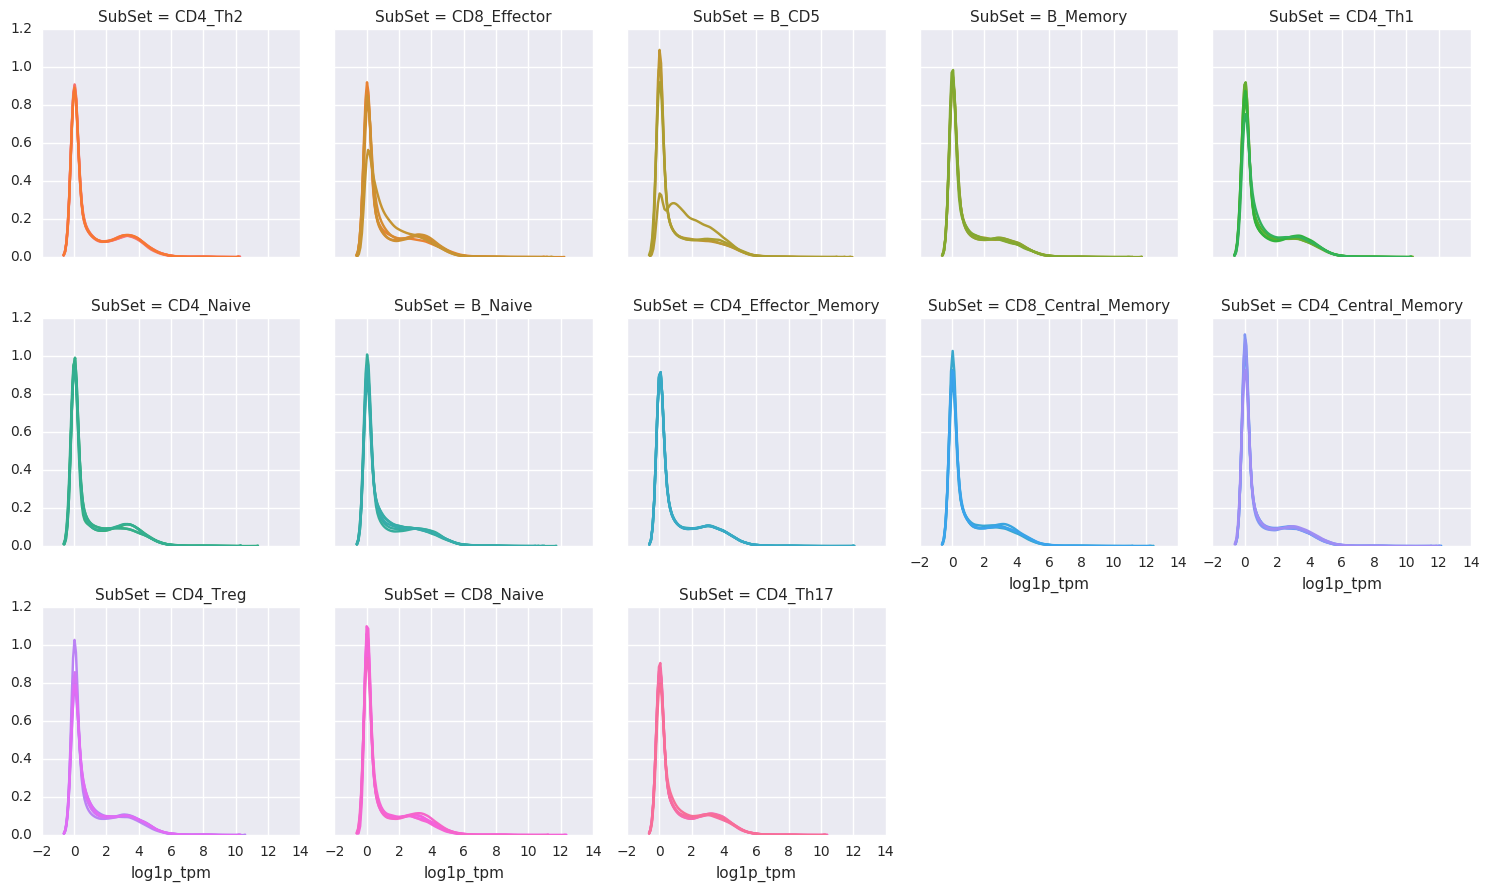

In [5]:
g = sns.FacetGrid(annotated_summary, hue='sample_id', col='SubSet', col_wrap=5)
g.map(sns.distplot, 'log1p_tpm', hist=False)

We see from the above that, for the most part, there is a high degree of similarity in the distribution of `log1p(tpm)` among repeated samples of the same cell type. 

There are two notable exceptions:
- among `CD8_Effector` cells, there is at least one sample with a slightly different distribution of `log1p(tpm)`. This sample has a higher number of genes with `log1p(tpm)` between 1 and 3 than is observed in the toher cells.
- among `B_CD5` cells, there is also a single sample with a much lower frequency of genes with `log1p(tpm) == 0`. This sample may be an error, or it may represent a greater possibility of heterogeneity in this cell type than is observed in other cell types. 

We should confirm whether the number of samples is similar across cell types.

In [6]:
subsets.groupby('SubSet')['filename'].count()

SubSet
B_CD5                  4
B_Memory               5
B_Naive                5
CD4_Central_Memory     5
CD4_Effector_Memory    5
CD4_Naive              5
CD4_Th1                5
CD4_Th17               5
CD4_Th2                5
CD4_Treg               5
CD8_Central_Memory     4
CD8_Effector           5
CD8_Naive              5
Name: filename, dtype: int64

Based on the above, I would say we have similar number of samples for each cell type. 

It's also worthwhile to remember that the exploration above doesn't say anything about whether samples have similar values *for the same transcript or gene*. This only looks at how similarly the values are distributed. 

The distribution of values is useful because it will inform our data-simulations, and because it gives us an idea of how to approach the modeling task.

### Distribution of `log1p(tpm)` by cell type

Now that we know the distribution across samples within cell types are (for the most part) very similar to one another, we can take a short-cut and sum over the samples for each cell type in order to compare distribution of `log1p(tpm)` across cell types. 



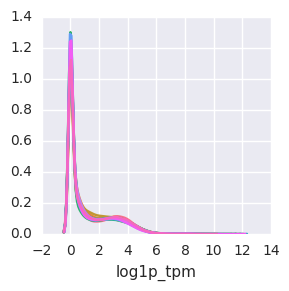

In [7]:
g = sns.FacetGrid(annotated_summary, hue='SubSet')
g.map(sns.distplot, 'log1p_tpm', hist=False)

Based on the above, it appears that each cell type has a mixture of two distributions of counts 
- one centered at `log1p(tpm) == 0` or `tpm ~ 0`
- another centered at `log1p(tpm) == 3.5` or `tpm ~ 30`

We can double-check our math in converting log1p_tpm to tpm as follows:

In [8]:
np.expm1(3.5)

32.115451958692312

My current plan would be to estimate this mixture directly for each cell type & for each sample, such that the `log1p(tpm)` value for each gene would be drawn either from a narrow distribution centered at `0`, or a more diffuse distribution centered at `log1p(tpm)` of ~ 3.

## distribution of `log1p(read counts)` by cell type, across samples

Before we go too much further with this plan, it is also worthwhile to note that the `tpm` values are transformed representations of the read counts. Now, I trust the data-prep process but also feel it's useful to be familiar with the data.

As a sanity check, let's see how different the graphs we prepared above would look if they utilized `log1p(counts)` instead of `log1p(tpm)`.

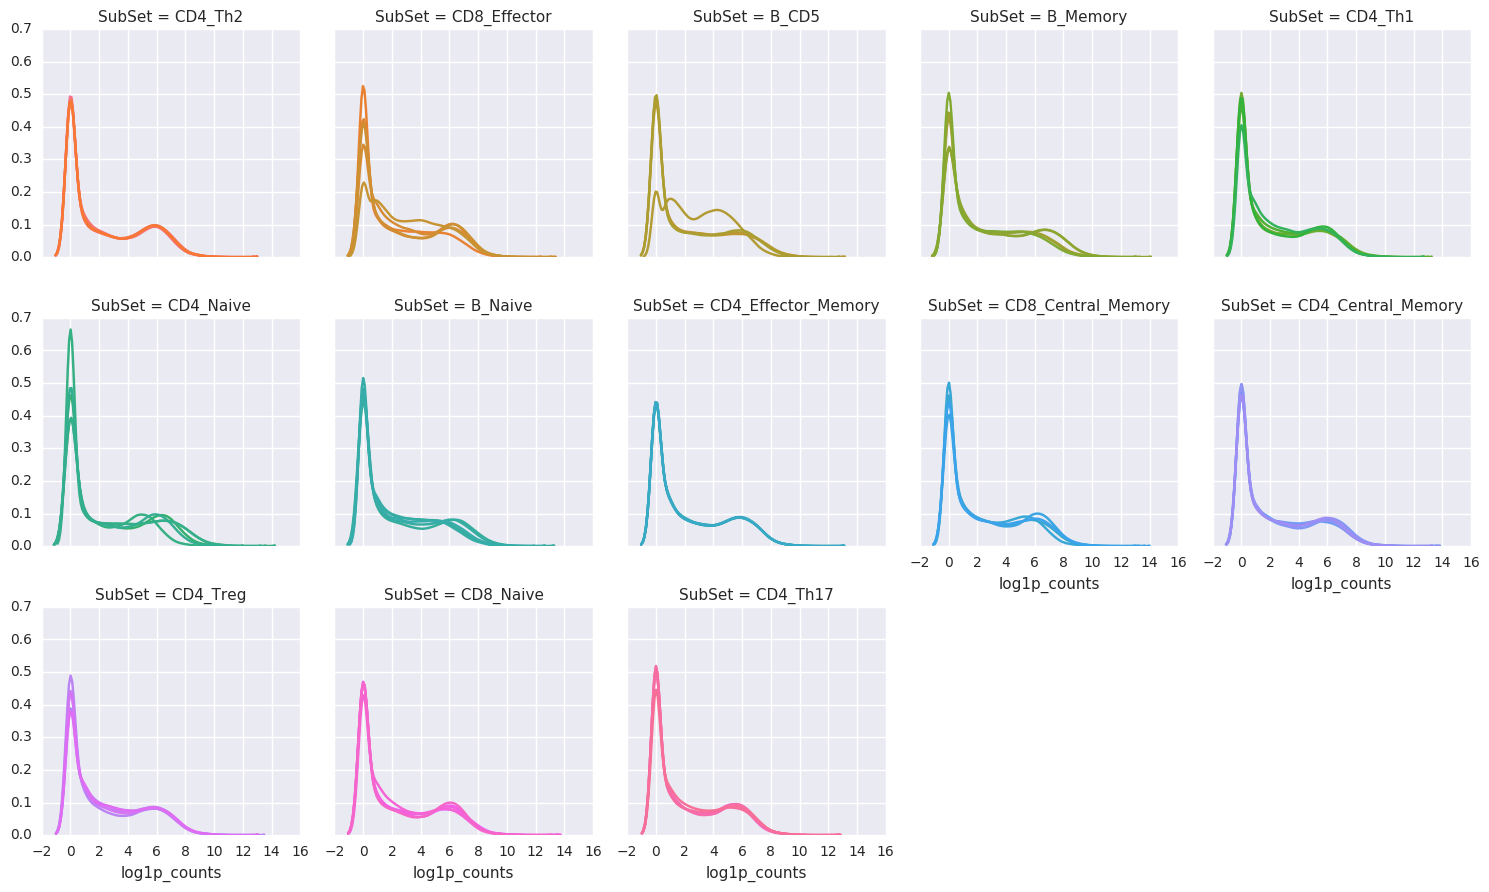

In [9]:
g = sns.FacetGrid(annotated_summary, hue='sample_id', col='SubSet', col_wrap=5)
g.map(sns.distplot, 'log1p_counts', hist=False)

Not that different! 

We do see a greater distinction of the aberrant samples noted earlier - among the `CD8_Effector` & `B_CD5` subsets. 

We also see (particularly among `CD4_Naive`, `B_Naive`, and `CD8_Central_Memory` cells that the mean of the "non-zero" mixture component is slightly different among samples with the same cell type. It's possible that the `tpm` transformation has normalized-away some of this noise. 

For now, we will proceed with the assumption that the primary value for each gene is `log1p(tpm)`. 

This will be useful to keep in mind as we move forward with modeling exercise, since without more information on the purpose of using `tpm` vs `counts` it will be hard to say whether this noise would or would not be informative.

## Summarize values by gene across samples within a cell type

In this section, we aim to determine how similar expression levels of particular genes are across samples within a cell type. 

We will first investigate this for one cell type (`B_Naive`) and then repeat the summary across all cell types. 

In [16]:
## normalize values across samples within each SubSet
annotated_summary['log1p_tpm_rescaled'] = annotated_summary \
            .groupby(['SubSet','gene_name'])['log1p_tpm'] \
            .transform(lambda x: (x - x.mean()) / x.std())


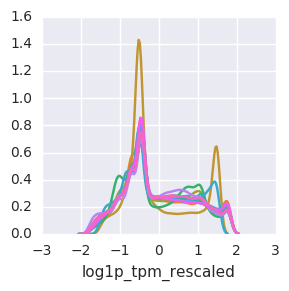

In [17]:
g = sns.FacetGrid(data=annotated_summary, hue='SubSet')
g.map(sns.distplot, 'log1p_tpm_rescaled', hist=False)

Not sure why these distributions are bi-modal. Ideally, we would want them to be normally-distributed, but .. then again we only have 5 samples for each subset. 

Let's try using the geometric mean & std to see if these yield better/more stable estimates.

In [36]:
from scipy.stats.mstats import gmean
def gstd(x):
    return np.exp(np.std(np.log(x)))

annotated_summary['log1p_tpm_rescaled2'] = annotated_summary \
            .groupby(['SubSet','gene_name'])['log1p_tpm'] \
            .transform(lambda x: (x - gmean(x)) / gstd(x))


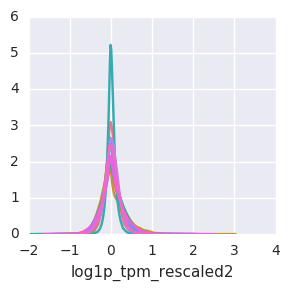

In [37]:
g = sns.FacetGrid(data=annotated_summary, hue='SubSet')
g.map(sns.distplot, 'log1p_tpm_rescaled2', hist=False)

Much better. We will use this method to rescale values going forward.

## Summarize values by gene across samples within cell super-type

Let's first identify parent-cell types for each of these samples. E.g. `B`, `CD4`, & `CD8`.

In [21]:
annotated_summary['cell_type'] = annotated_summary['SubSet'].apply(lambda x: x.split('_')[0])

In [22]:
annotated_summary.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CD4,CD45RA,CD45RO,CD5,CD8,CRTH2,CXCR3,SubSet,log1p_tpm_rescaled,cell_type
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,+,None,None,None,None,+,-,CD4_Th2,-0.985596,CD4
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,+,None,None,None,None,+,-,CD4_Th2,-1.212457,CD4
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,+,None,None,None,None,+,-,CD4_Th2,-0.376555,CD4
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,+,None,None,None,None,+,-,CD4_Th2,1.062100,CD4
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,+,None,None,None,None,+,-,CD4_Th2,1.704980,CD4


In [34]:
## normalize values across samples within each SubSet
## use geometric mean & sd rather than mean & sd to control for skewness
annotated_summary['log1p_tpm_rescaled_type'] = annotated_summary \
            .groupby(['cell_type','gene_name'])['log1p_tpm'] \
            .transform(lambda x: (x - gmean(x)) / gstd(x))


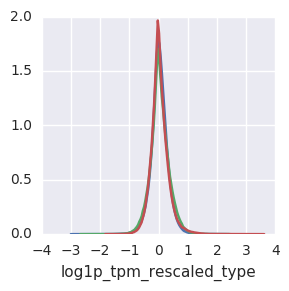

In [35]:
g = sns.FacetGrid(data=annotated_summary, hue='cell_type')
g.map(sns.distplot, 'log1p_tpm_rescaled_type', hist=False)

## Summarize values by gene across cell type

In this next section, we aim to compare values of `log1p(tpm)` across cell types for the same gene. 

In order to do this properly, we will want to rescale the values for each gene (transcript), so that the magnitude of the difference can be summarized relative to the average level of expression. 

First we will summarize the `log1p(tpm)` value for each gene and for each subset, using the mean value across samples. 


In [38]:
annotated_summary['log1p_tpm_rescaled'] = annotated_summary \
            .groupby('gene_name')['log1p_tpm'] \
            .transform(lambda x: (x - gmean(x)) / gstd(x))


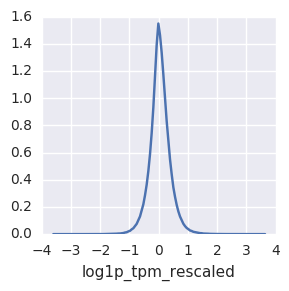

In [41]:
g = sns.FacetGrid(data=annotated_summary)
g.map(sns.distplot, 'log1p_tpm_rescaled', hist=False)

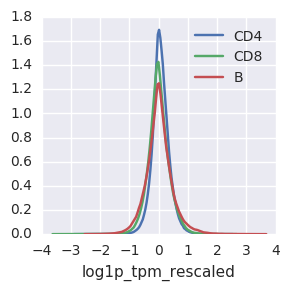

In [44]:
g = sns.FacetGrid(data=annotated_summary, hue='cell_type')
g.map(sns.distplot, 'log1p_tpm_rescaled', hist=False)
plt.legend()

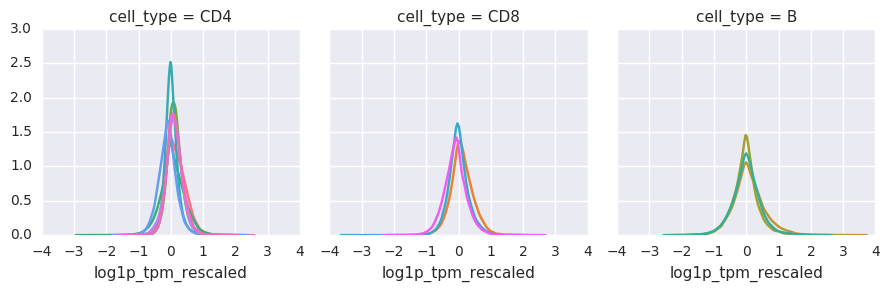

In [45]:
g = sns.FacetGrid(data=annotated_summary, hue='SubSet', col='cell_type')
g.map(sns.distplot, 'log1p_tpm_rescaled', hist=False)

In [61]:
summarized = annotated_summary.groupby(['SubSet','cell_type', 'gene_name']).agg({'log1p_tpm_rescaled': np.mean, 'log1p_tpm': gmean}).reset_index()
summarized['rank'] = summarized.groupby('SubSet')["log1p_tpm"].rank()

In [62]:
summarized_wide = summarized.pivot(index='gene_name', columns='SubSet', values='rank')
summarized_wide.reset_index(inplace=True)
summarized = pd.merge(summarized, summarized_wide, on='gene_name', how='inner')

In [63]:
summarized.head()

,SubSet,cell_type,gene_name,log1p_tpm_rescaled,log1p_tpm,rank,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,CD4_Treg,CD8_Central_Memory,CD8_Effector,CD8_Naive
0,B_CD5,B,A1BG,0.065631,2.703374,28036.0,28036.0,28721.0,28234.0,28260.0,27822.0,26479.0,26352.0,26830.0,25867.0,27677.0,29348.0,28148.0,30405.0
1,B_Memory,B,A1BG,0.136489,2.804937,28721.0,28036.0,28721.0,28234.0,28260.0,27822.0,26479.0,26352.0,26830.0,25867.0,27677.0,29348.0,28148.0,30405.0
2,B_Naive,B,A1BG,0.061503,2.686858,28234.0,28036.0,28721.0,28234.0,28260.0,27822.0,26479.0,26352.0,26830.0,25867.0,27677.0,29348.0,28148.0,30405.0
3,CD4_Central_Memory,CD4,A1BG,-0.035413,2.610979,28260.0,28036.0,28721.0,28234.0,28260.0,27822.0,26479.0,26352.0,26830.0,25867.0,27677.0,29348.0,28148.0,30405.0
4,CD4_Effector_Memory,CD4,A1BG,0.032378,2.701419,27822.0,28036.0,28721.0,28234.0,28260.0,27822.0,26479.0,26352.0,26830.0,25867.0,27677.0,29348.0,28148.0,30405.0


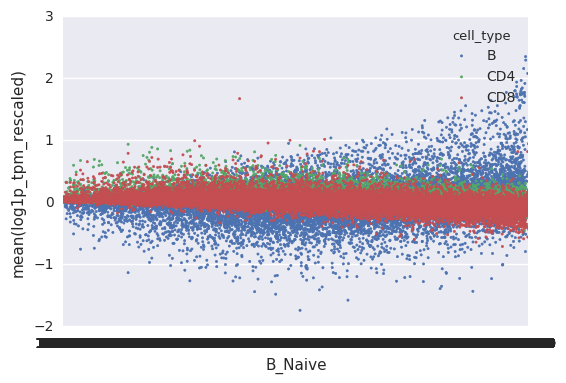

In [65]:
sns.pointplot(data=summarized,
              x='B_Naive', y='log1p_tpm_rescaled', hue='cell_type',
              join=False, scale=0.2, ci=None, alpha=0.02)